In [113]:
import os
import numpy as np
import nibabel as nib
import random
import matplotlib.pyplot as plt 
from tifffile import imwrite
from tensorflow.keras.utils import to_categorical
import glob
import splitfolders
from tqdm.notebook import tqdm  # Versión específica para Jupyter
from skimage.transform import resize

import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [114]:
# Definir el escalador
scaler = StandardScaler()

# Ruta al conjunto de datos de BraTS2024
TRAIN_DATASET_PATH = 'data/BraTS2025-GLI-PRE-Challenge-TrainingData/'
# TRAIN_DATASET_PATH = 'data/test/'

### Mostrar para una imagen

In [115]:
# Función para cargar y escalar las imágenes de MRI
def load_and_scale_image(file_path):
    """
    Carga una imagen NIfTI (.nii/.nii.gz) y la escala usando MinMaxScaler.
    """
    # Cargar la imagen
    image = nib.load(file_path).get_fdata()
    
    # Escalar la imagen. Aplanamos la imagen a un vector para aplicar el escalado, 
    # luego la reconfiguramos a su forma original.
    image_scaled = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
    
    return image_scaled

# Cargar y escalar las imágenes de las distintas modalidades
# Estas son las modalidades del dataset BraTS2025 para este ejemplo

# FLAIR: T2f Fluid-Attenuated Inversion Recovery 
test_image_flair = load_and_scale_image(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2f.nii.gz')
print("T2f - FLAIR Image Max Value (after scaling):", test_image_flair.max())

# T1 Non-contrast: T1 sin contraste
test_image_t1 = load_and_scale_image(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1n.nii.gz')
print("T1n - T1 Native / Non-contrast Image Max Value (after scaling):", test_image_t1.max())

# T1 Contrast Enhanced: T1 con contraste
test_image_t1ce = load_and_scale_image(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-t1c.nii.gz')
print("t1c - T1 Contrast Enhanced Image Max Value (after scaling):", test_image_t1ce.max())

# T2w Weighted: T2w ponderado
test_image_t2w = load_and_scale_image(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2w.nii.gz')
print("t2w - T2 Weighted Image Max Value (after scaling):", test_image_t2w.max())

# Cargar la máscara de segmentación
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00000-000/BraTS-GLI-00000-000-seg.nii.gz').get_fdata()

# Asegurarnos de que la máscara esté en formato uint8 (para asegurar que las etiquetas sean de 0-255)
test_mask = test_mask.astype(np.uint8)

# Verificar las etiquetas presentes en la máscara
print("Unique mask values (before reencoding):", np.unique(test_mask))  # Deberían ser [0, 1, 2, 4]

T2f - FLAIR Image Max Value (after scaling): 120.55941704306306
T1n - T1 Native / Non-contrast Image Max Value (after scaling): 87.64468715356843
t1c - T1 Contrast Enhanced Image Max Value (after scaling): 97.49851009064926
t2w - T2 Weighted Image Max Value (after scaling): 124.33040927170693
Unique mask values (before reencoding): [0 1 2 3]


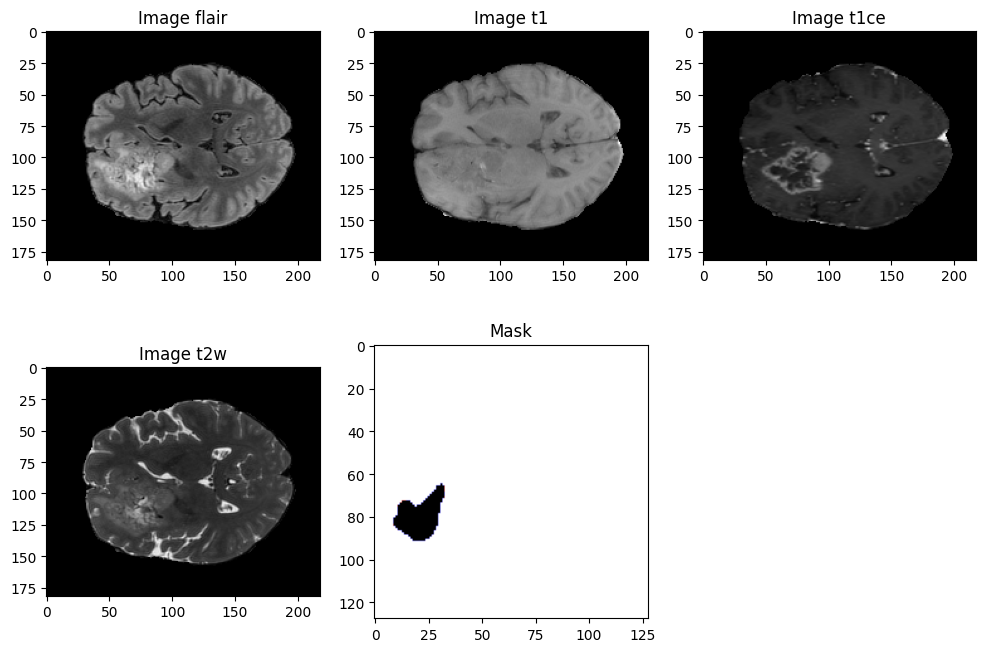

In [129]:
# Mostrar una imagen aleatoria
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2w[:,:,n_slice], cmap='gray')
plt.title('Image t2w')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

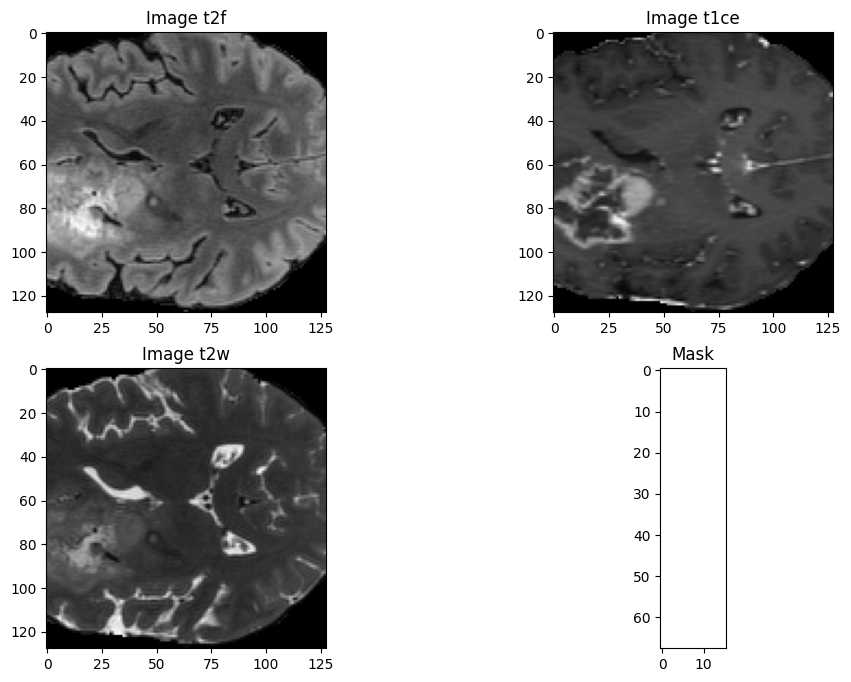

In [134]:
'''Combining all 4 images to 4 channels of a numpy array.
Combine t1ce, t2w, and t2f into single multichannel image
'''
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2w], axis=3)

combined_x=combined_x[30:158, 56:184, 13:141] #Crop to 128x128x128x4

test_mask = test_mask[30:158, 56:184, 13:141]#The same for mask


n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image t2f')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2w')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [118]:
# Asegurarse de que el directorio de salida exista
output_dir = 'data/BraTS2025-GLI-PRE-Challenge-TrainingData-Combined/'
os.makedirs(output_dir, exist_ok=True)

# Guardar archivos multicanal como .tif y .npy
imwrite(os.path.join(output_dir, 'combined-0000-000.tif'), combined_x)
np.save(os.path.join(output_dir, 'combined-0000-000.npy'), combined_x)  # Guardar como np array

# Cargar el archivo guardado como ejemplo
my_img = np.load(os.path.join(output_dir, 'combined-0000-000.npy'))

# Convertir la máscara a formato categórico
test_mask = to_categorical(test_mask, num_classes=4)


### Todas las imágenes

In [119]:
#All images TRAINING
t2w_list_training  = sorted(glob.glob(f'{TRAIN_DATASET_PATH}/*/*t2w.nii.gz'))
t1c_list_training  = sorted(glob.glob(f'{TRAIN_DATASET_PATH}/*/*t1c.nii.gz'))
t1n_list_training  = sorted(glob.glob(f'{TRAIN_DATASET_PATH}/*/*t1n.nii.gz'))
t2f_list_training  = sorted(glob.glob(f'{TRAIN_DATASET_PATH}/*/*t2f.nii.gz'))
mask_list_training = sorted(glob.glob(f'{TRAIN_DATASET_PATH}/*/*seg.nii.gz'))

#### Prepocesado

##### Funciones de procesamiento de imágenes


In [120]:
def process_image(image_path, scaler):
    """
    Carga y normaliza una imagen MRI
    
    Args:
        image_path: Ruta a la imagen
        scaler: Objeto StandardScaler para normalización
        
    Returns:
        Imagen normalizada
    """
    temp_image = nib.load(image_path).get_fdata()
    temp_image = scaler.fit_transform(temp_image.reshape(-1, temp_image.shape[-1])).reshape(temp_image.shape)
    return temp_image

def process_mask(mask_path):
    """
    Carga y prepara una máscara
    
    Args:
        mask_path: Ruta a la máscara
        
    Returns:
        Máscara convertida a uint8
    """
    temp_mask = nib.load(mask_path).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    return temp_mask



##### Funciones de análisis y guardado


In [121]:

def analyze_mask(mask):
    """
    Analiza una máscara para obtener estadísticas
    
    Args:
        mask: Máscara a analizar
        
    Returns:
        Diccionario con valores y conteos únicos, y ratio de no-fondo
    """
    val, counts = np.unique(mask, return_counts=True)
    total_voxels = mask.size
    
    # Verificar si hay valores de tumor (1, 2, 3 o 4 dependiendo del dataset)
    # En BraTS, generalmente 1=necrosis, 2=edema, 4=tumor enhancing
    tumor_mask = mask > 0
    tumor_voxels = np.sum(tumor_mask)
    non_bg_ratio = tumor_voxels / total_voxels
    
    # Crear diccionario de conteo de etiquetas
    label_counts = {int(v): int(c) for v, c in zip(val, counts)}
    
    return {
        'values': val,
        'counts': counts,
        'non_bg_ratio': non_bg_ratio,
        'label_counts': label_counts
    }

def save_processed_data(combined_images, mask, save_dir, img_index):
    """
    Guarda las imágenes procesadas y máscaras en archivos .npy
    
    Args:
        combined_images: Imágenes combinadas a guardar
        mask: Máscara categorizada a guardar
        save_dir: Directorio base donde guardar
        img_index: Índice de la imagen
        
    Returns:
        Diccionario con rutas donde se guardaron los archivos
    """
    # Definir la ruta de las carpetas
    images_dir = os.path.join(save_dir, 'input_data_3channels/images/')
    masks_dir = os.path.join(save_dir, 'input_data_3channels/mask/')

    # Crear las carpetas si no existen
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(masks_dir, exist_ok=True)
    
    # Generar nombres de archivos
    img_path = os.path.join(images_dir, f'image_{img_index}.npy')
    mask_path = os.path.join(masks_dir, f'mask_{img_index}.npy')
    
    # Guardar archivos
    np.save(img_path, combined_images)
    np.save(mask_path, mask)
    
    return {
        'image_path': img_path,
        'mask_path': mask_path
    }



##### Función de visualización de resultados


In [122]:
def visualize_results(results):
    """
    Visualiza los resultados del procesamiento con gráficos
    
    Args:
        results: Lista de diccionarios con resultados
    """
    # Preparar datos para gráficos
    statuses = [r['status'] for r in results]
    status_counts = {
        'Procesadas': statuses.count('processed'),
        'Descartadas': statuses.count('skipped'),
        'Error': statuses.count('error')
    }
    
    # Gráfico de barras para estados
    plt.figure(figsize=(12, 6))
    
    # Gráfico 1: Estado de las imágenes
    plt.subplot(1, 2, 1)
    colors = ['#4CAF50', '#FFC107', '#F44336']
    plt.bar(status_counts.keys(), status_counts.values(), color=colors)
    plt.title('Estado de procesamiento de imágenes')
    plt.ylabel('Número de imágenes')
    plt.grid(axis='y', alpha=0.3)
    
    # Añadir etiquetas con valores
    for i, (key, value) in enumerate(status_counts.items()):
        plt.text(i, value + 0.5, str(value), ha='center')
    
    # Gráfico 2: Distribución de ratio de no-fondo
    plt.subplot(1, 2, 2)
    ratios = [r['non_bg_ratio'] for r in results if 'non_bg_ratio' in r]
    if ratios:
        sns.histplot(ratios, bins=20, kde=True)
        plt.axvline(x=0.01, color='red', linestyle='--', 
                   label='Umbral de selección (1%)')
        plt.title('Distribución de porcentaje de voxels no-fondo')
        plt.xlabel('Ratio de voxels no-fondo')
        plt.ylabel('Frecuencia')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Gráfico adicional: Distribución de clases en las imágenes procesadas
    processed_results = [r for r in results if r['status'] == 'processed' and 'label_counts' in r]
    if processed_results:
        # Recopilar conteos por etiqueta
        label_totals = {}
        for r in processed_results:
            for label, count in r['label_counts'].items():
                if label not in label_totals:
                    label_totals[label] = 0
                label_totals[label] += count
        
        # Crear gráfico
        plt.figure(figsize=(10, 6))
        labels = list(label_totals.keys())
        counts = list(label_totals.values())
        
        colors = ['#EEEEEE', '#1E88E5', '#FFC107', '#D81B60']
        plt.bar(labels, counts, color=[colors[int(l)] if int(l) < len(colors) else '#AAAAAA' for l in labels])
        plt.title('Distribución de clases en las imágenes')
        plt.xlabel('Clase')
        plt.ylabel('Número de voxels')
        plt.yscale('log')
        plt.xticks(labels)
        plt.grid(axis='y', alpha=0.3)
        
        # Añadir porcentajes
        total = sum(counts)
        for i, count in enumerate(counts):
            percentage = count / total * 100
            plt.text(labels[i], count, f'{percentage:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()


##### Función principal de procesamiento


Procesando imágenes:   0%|          | 0/500 [00:00<?, ?it/s]

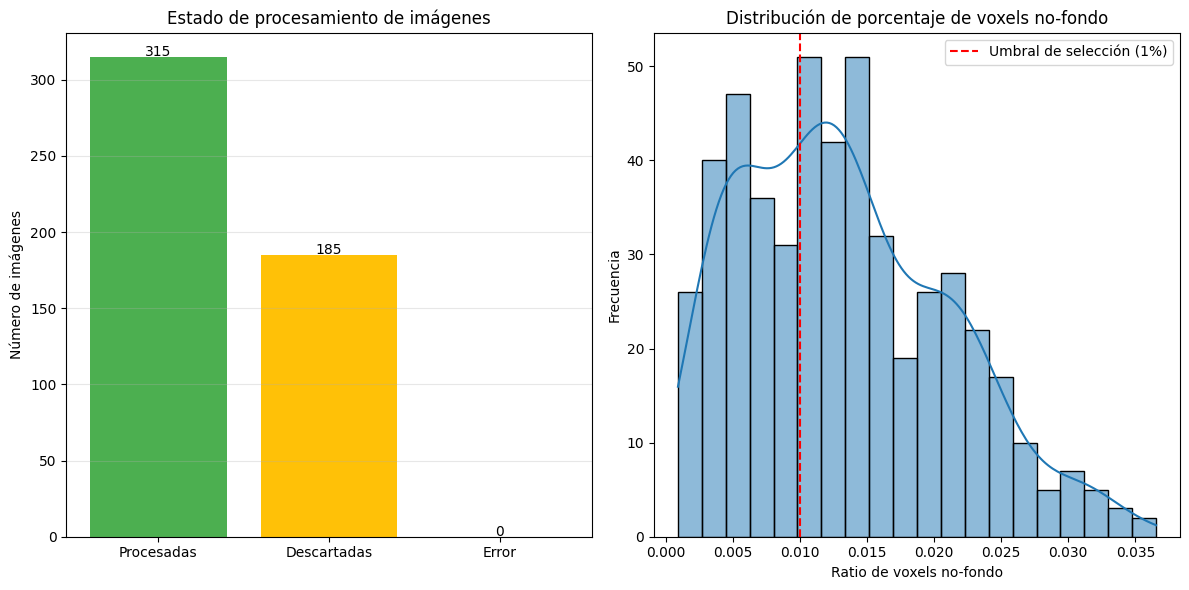

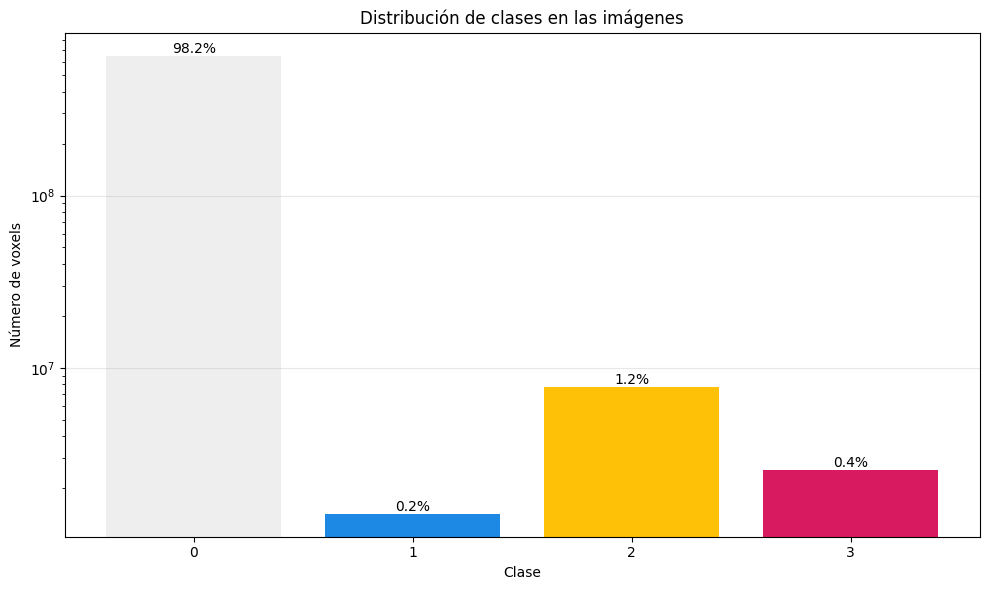

In [123]:

def process_batch(t2w_list, t1c_list, t1n_list, t2f_list, mask_list, save_dir, threshold=0.01):
    """
    Procesa un lote de imágenes y máscaras
    
    Args:
        t2w_list: Lista de rutas a imágenes T2W
        t1c_list: Lista de rutas a imágenes T1C
        t1n_list: Lista de rutas a imágenes T1N
        t2f_list: Lista de rutas a imágenes T2F
        mask_list: Lista de rutas a máscaras
        save_dir: Directorio donde guardar los resultados
        threshold: Umbral de ratio de no-fondo para considerar útil una imagen
        
    Returns:
        Lista de resultados del procesamiento
    """
    scaler = StandardScaler()
    results = []
    
    for img in tqdm(range(len(t2w_list)), desc="Procesando imágenes"):
        result = {
            'index': img,
            'status': 'error',  # Por defecto asumimos error, y lo actualizamos si todo va bien
        }
        
        try:
            # Procesar las diferentes modalidades de imágenes
            temp_image_t2w = process_image(t2w_list[img], scaler)
            temp_image_t1c = process_image(t1c_list[img], scaler)
            temp_image_t1n = process_image(t1n_list[img], scaler)
            temp_image_t2f = process_image(t2f_list[img], scaler)
            
            # Procesar máscara
            temp_mask = process_mask(mask_list[img])
            
            # Combinar imágenes
            temp_combined_images = np.stack([temp_image_t2f, temp_image_t1c, temp_image_t1n, temp_image_t2w], axis=3)
            
            # Redimensionar directamente a 128x128x128
            temp_combined_images = resize(temp_combined_images, (128, 128, 128, temp_combined_images.shape[-1]),
                                        order=1, preserve_range=True, anti_aliasing=False).astype(temp_combined_images.dtype)

            temp_mask = resize(temp_mask, (128, 128, 128),
                       order=0, preserve_range=True, anti_aliasing=False).astype(temp_mask.dtype)


            
            # Analizar la máscara
            mask_analysis = analyze_mask(temp_mask)
            result.update(mask_analysis)
            
            # Determinar si la imagen es útil basándonos en el umbral
            if mask_analysis['non_bg_ratio'] > threshold:
                
                # Convertir máscara a one-hot encoding
                temp_mask_categorical = to_categorical(temp_mask, num_classes=4)
                
                # Guardar datos procesados
                save_info = save_processed_data(temp_combined_images, temp_mask_categorical, save_dir, img)
                result.update(save_info)
                result['status'] = 'processed'
            else:
                result['status'] = 'skipped'
            
        except Exception as e:
            print(f"Error procesando imagen {img}: {str(e)}")
            result['error'] = str(e)
        
        results.append(result)
        
    return results

# Procesar las imágenes
results = process_batch(
    t2w_list_training, 
    t1c_list_training, 
    t1n_list_training, 
    t2f_list_training, 
    mask_list_training, 
    TRAIN_DATASET_PATH
)

# Visualizar resultados
visualize_results(results)


...

Archivos de imágenes procesadas: 500
Archivos de máscaras procesadas: 500

Muestra del archivo image_242.npy:
- Forma de la imagen: (128, 128, 128, 4)
- Rango de valores: [-0.8821, 44.8279]
- Forma de la máscara: (128, 128, 128, 4)
- Clases en la máscara: 4 (one-hot encoding)


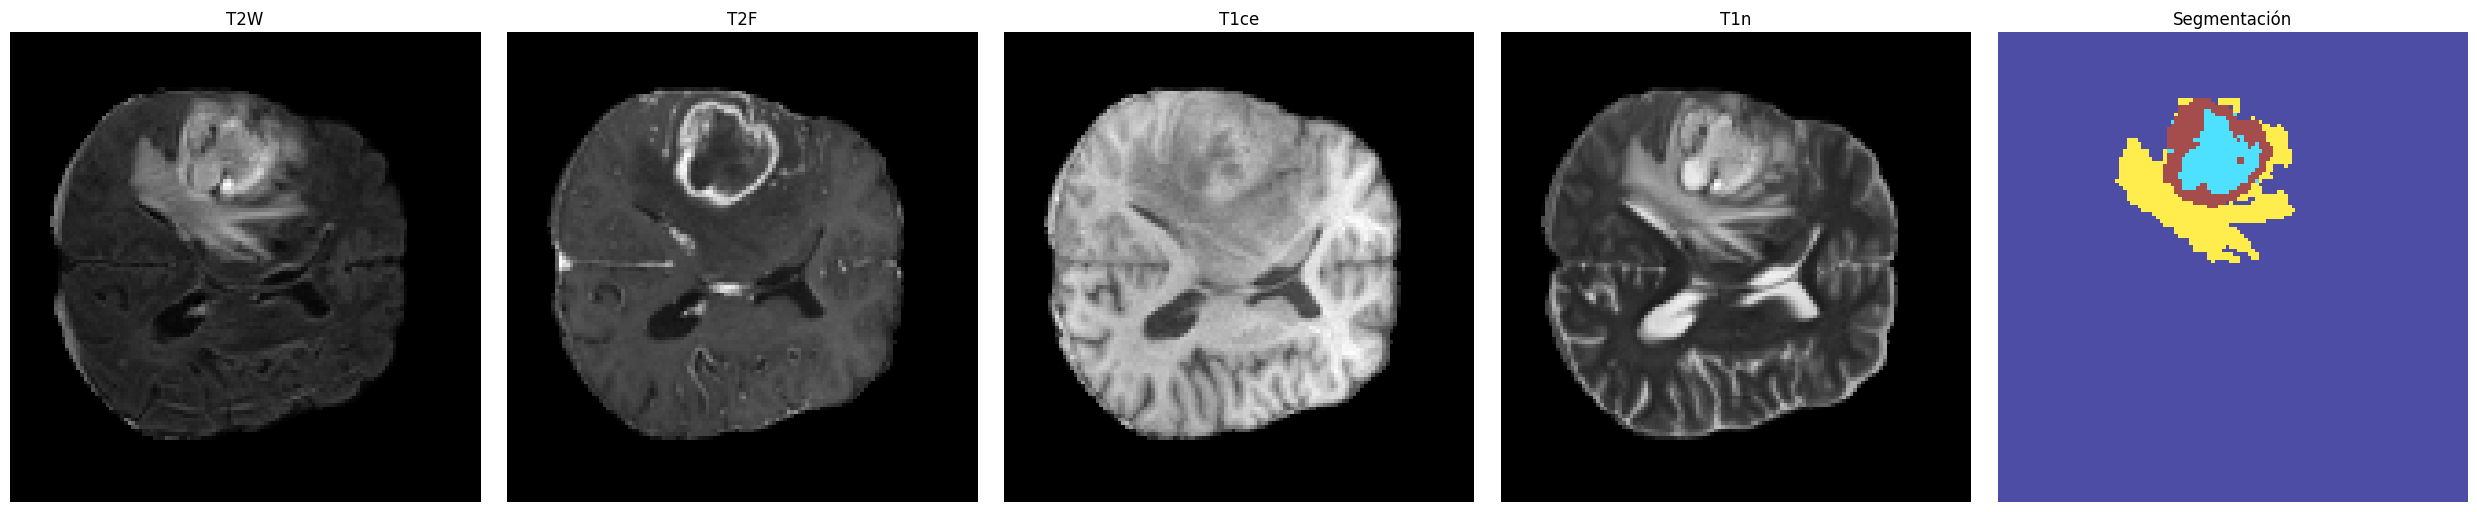

In [132]:
def check_processed_data(images_dir, masks_dir):
    """
    Verifica los datos procesados y muestra estadísticas básicas
    
    Args:
        images_dir: Directorio donde se encuentran las imágenes procesadas
        masks_dir: Directorio donde se encuentran las máscaras procesadas
    
    Returns:
        Tupla (sample_img, sample_mask) con una muestra de los datos procesados
    """
    processed_images_files = sorted(glob.glob(f"{images_dir}/*.npy"))
    processed_masks_files = sorted(glob.glob(f"{masks_dir}/*.npy"))
    
    print(f"Archivos de imágenes procesadas: {len(processed_images_files)}")
    print(f"Archivos de máscaras procesadas: {len(processed_masks_files)}")
    
    if len(processed_images_files) > 0:
        # Cargar una imagen aleatoria para verificar
        import random
        sample_idx = random.randint(0, len(processed_images_files)-1)
        sample_img = np.load(processed_images_files[sample_idx])
        sample_mask = np.load(processed_masks_files[sample_idx])
        
        print(f"\nMuestra del archivo {processed_images_files[sample_idx].split('/')[-1]}:")
        print(f"- Forma de la imagen: {sample_img.shape}")
        print(f"- Rango de valores: [{sample_img.min():.4f}, {sample_img.max():.4f}]")
        print(f"- Forma de la máscara: {sample_mask.shape}")
        print(f"- Clases en la máscara: {sample_mask.shape[-1]} (one-hot encoding)")
        
        # Visualizar un corte de la imagen
        slice_idx = sample_img.shape[2] // 2  # Corte central en el eje Z
        
        # Determinar cuántas columnas necesitamos en función del número de canales
        num_channels = sample_img.shape[3]
        fig_width = 5 * (num_channels + 1)  # +1 para la máscara
        
        plt.figure(figsize=(fig_width, 5))
        
        # Imagen T2W
        plt.subplot(1, num_channels + 1, 1)
        plt.imshow(sample_img[:, :, slice_idx, 0], cmap='gray')
        plt.title('T2W')
        plt.axis('off')
        
        # Imagen T2F
        plt.subplot(1, num_channels + 1, 2)
        plt.imshow(sample_img[:, :, slice_idx, 1], cmap='gray')
        plt.title('T2F')
        plt.axis('off')
        
        # Imagen T1ce
        plt.subplot(1, num_channels + 1, 3)
        plt.imshow(sample_img[:, :, slice_idx, 2], cmap='gray')
        plt.title('T1ce')
        plt.axis('off')
        
        # Imagen T1n
        plt.subplot(1, num_channels + 1, 4)
        plt.imshow(sample_img[:, :, slice_idx, 3], cmap='gray')
        plt.title('T1n')
        plt.axis('off')
        
        # Máscara (combinando todas las clases con colores diferentes)
        plt.subplot(1, num_channels + 1, 5)
        mask_vis = np.zeros(sample_mask.shape[0:3])
        for i in range(1, sample_mask.shape[3]):  # Saltamos la clase 0 (fondo)
            mask_vis += i * sample_mask[:, :, :, i]
        
        plt.imshow(mask_vis[:, :, slice_idx], cmap='jet', alpha=0.7)
        plt.title('Segmentación')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return sample_img, sample_mask
    else:
        print("No se encontraron archivos procesados.")
        return None, None
    
images_dir = os.path.join(TRAIN_DATASET_PATH, 'input_data_3channels/images')
masks_dir = os.path.join(TRAIN_DATASET_PATH, 'input_data_3channels/mask')
sample_img, sample_mask = check_processed_data(images_dir, masks_dir)

In [125]:
#Splitting folder into train, test, and val.
input_folder = TRAIN_DATASET_PATH + '/input_data_3channels/'
output_folder = TRAIN_DATASET_PATH + '/input_data_128/'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 1000 files [04:24,  3.79 files/s]
